Most of this code is modified from Daniel Kennedy's code for parameter selection (on Github; https://github.com/djk2120/CLM5PPE/blob/master/pyth/param_selection.ipynb) 

# Set up workspace

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
#from altair import datum

# Define functions for reading in PPE data
(code from Daniel Kennedy)

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    """Code from Daniel Kennedy"""
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='UWAS0044', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(20)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36460 instead
  http_address["port"], self.http_server.port


In [4]:
client

Client Scheduler: tcp://10.12.206.54:36116 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/czarakas/proxy/{port}/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
def get_params(keys,paramkey):
    """Code from Daniel Kennedy"""
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [6]:
def month_wts(nyears):
    """Code from Daniel Kennedy"""
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [7]:
def get_ensemble(name,data_vars,htape,keys,paramkey):
    """Code from Daniel Kennedy"""
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=True,preprocess=preprocess)

    #fix up time dimension
    if htape=='h0':
        ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat','grid1d_lon']
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    whit         = xr.open_dataset('./whit/whitkey.nc') #('./whit/whitkey2.nc')
    ds['biome']      = whit['biome']
    ds['biome_name'] = whit['biome_name']
    
    return ds

In [8]:
def calc_mean(ds,datavar):
    """Code modified from code from Daniel Kennedy"""
    cf = cfs[datavar]
    x  = ds[datavar]
    
    da_ann  = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum(dim='time').compute()
    da_mean = da_ann.mean(dim='year') 
    
    return da_mean,da_ann

In [9]:
def calc_iav(ds,datavar,da_ann=[]):
    """Code modified from code from Daniel Kennedy"""
    #compute da_ann if not provided
    if len(da_ann)==0:
        cf = cfs[datavar]
        x  = ds[datavar]
        da_ann  = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum().compute()
    da_iav = da_ann.std(dim='year')
    return da_iav

In [10]:
def top_n(da,nx,params,minmax,uniques):
    """ Code from Daniel Kennedy """
    xmins=[];xmaxs=[];dxs=[]
    for u in uniques:
        pair  = find_pair(da,params,minmax,u)
        xmin  = pair[0].values
        xmax  = pair[1].values
        dx    = abs(xmax-xmin)

        xmins.append(xmin)
        xmaxs.append(xmax)
        dxs.append(dx)

    ranks = np.argsort(dxs)

    pvals = [uniques[ranks[i]] for i in range(-nx,0)]
    xmins = [xmins[ranks[i]]   for i in range(-nx,0)]
    xmaxs = [xmaxs[ranks[i]]   for i in range(-nx,0)]
    
    return xmins,xmaxs,pvals

In [11]:
def find_pair(da,params,minmax,p):
    '''
    Code from Daniel Kennedy
    returns a subset of da, corresponding to parameter-p
        the returned pair corresponds to [p_min,p_max]
    '''
    ixmin = np.logical_and(params==p,minmax=='min')
    ixmax = np.logical_and(params==p,minmax=='max')
    
    #sub in default if either is missing
    if ixmin.sum().values==0:
        ixmin = params=='default'
    if ixmax.sum().values==0:
        ixmax = params=='default'
        
    emin = da.ens.isel(ens=ixmin).values[0]
    emax = da.ens.isel(ens=ixmax).values[0]

    return da.sel(ens=[emin,emax])

In [38]:
def plot20(da,nx,tstr,ll=True,xstr=''):
    
    uniques = list(np.unique(ds.param))
    uniques.remove('default')
    
    xmins,xmaxs,pvals = top_n(da,nx,params,minmax,uniques)
    xdef = da.isel(ens=0)
    unit = da.attrs['units']
    

    
    if len(xstr)==0:
        xstr=tstr
    nx = len(pvals)
    plt.plot([xdef,xdef],[0,nx-1],'k:',label='default')
    plt.scatter(xmins,range(nx),marker='o',facecolors='none', edgecolors='r',label='low-val')
    plt.plot(xmaxs,range(nx),'ro',label='high-val')
    if ll:
        plt.legend(loc=3)
    i=-1
    for xmin,xmax in zip(xmins,xmaxs):
        i+=1
        plt.plot([xmin,xmax],[i,i],'r')
    plt.yticks(range(nx),pvals)
    plt.title(tstr)
    plt.xlabel(xstr+' ('+unit+')');
    
def plot20(datavar,xdef,xmins,xmaxs,pvals,op,unit):
    nx = len(pvals)
    plt.plot([xdef,xdef],[0,nx-1],'k:',label='default')
    plt.scatter(xmins,range(nx),marker='o',facecolors='none', edgecolors='r',label='low-val')
    plt.plot(xmaxs,range(nx),'ro',label='high-val')
    plt.legend()
    i=-1
    for xmin,xmax in zip(xmins,xmaxs):
        i+=1
        plt.plot([xmin,xmax],[i,i],'r')
    plt.yticks(range(nx),pvals)
    plt.title(datavar+'_'+op)
    plt.xlabel(datavar+'_'+op+' ('+unit+')');

# Read in Data

In [13]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/firstpass.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

In [14]:
#choose your subset of variables
data_vars = ['FIRE','FSA','FSDSVD','FSRVD','FSDSND', 'FSRND','FSDSVI', 'FSRVI','FSDSNI', 'FSRNI',
             'FSR','FSDS','EFLX_LH_TOT','FSH',
             'QVEGT','QVEGE','QSOIL',
             'TSA','TSKIN',
             'Q2M',
             'TAUX','TAUY','U10']

keys = paramkey.key

#read in the dataset
ds = get_ensemble('CTL2010',data_vars,'h0',keys,paramkey)

In [15]:
uniques = np.unique(ds.param)
ix = uniques=='default'
uniques = uniques[~ix]

### Calculate new variables

In [16]:
ds['albedo_allSW'] = ds['FSR']/ds['FSDS']
ds['albedo_allSW'].attrs['units']='unitless'
ds['alb_DirVis'] = ds['FSRVD']/ds['FSDSVD']
ds['alb_DirVis'].attrs['units']='unitless'
ds['alb_DirNIR'] = ds['FSRND']/ds['FSDSND']
ds['alb_DirNIR'].attrs['units']='unitless'
ds['alb_DifVis'] = ds['FSRVI']/ds['FSDSVI']
ds['alb_DifVis'].attrs['units']='unitless'
ds['alb_DifNIR'] = ds['FSRNI']/ds['FSDSNI']
ds['alb_DifNIR'].attrs['units']='unitless'

ds['ET'] = ds['QVEGT']+ds['QVEGE']+ds['QSOIL']
ds['ET'].attrs['units']=ds['QVEGT'].attrs['units']

In [17]:
data_vars2 = ['EFLX_LH_TOT',
              'FSH',
              'ET',
              'TAUX',
              'TAUY',
              'FIRE',
              'albedo_allSW',
              'alb_DirVis',
              'alb_DifVis',
              'alb_DirNIR',
              'alb_DifNIR',
              'FSA',
              'TSKIN',
              'TSA',
              'Q2M',
              'U10']

In [18]:
cfs = dict()             # Conversion Factors
units = dict()
lasum = la.sum().values
    
for field in data_vars2:
    #intensives (need to account for landarea)
    cfs[field]   = 1/la.sum()/365
    units[field] = ds[field].attrs['units']

# Biome by Biome analysis

In [19]:
env = 'CTL2010'
#@njit
def calc_mean_biome(dsb,datavar,lab):

    domain='biome'
    preload = './data/'+env+'_'+datavar+'_'+domain+'.nc'
    
    if not glob.glob(preload):
        #do the calculation
        cf = cfs[datavar]  #conversion factor
        if cf=='intrinsic':
            cf = 1/lab.groupby('biome').sum()/365
        x  = dsb[datavar]

        #calc annual mean or sum (determined by cf)
        xann = cf*(month_wts(10)*(lab*x).groupby('biome').sum()).groupby('time.year').sum().compute()

        #average/iav
        xm  = xann.mean(dim='year') 
        iav = xann.std(dim='year')

        #save the reduced data
        out = xr.Dataset()
        out[datavar+'_mean'] = xm
        out[datavar+'_mean'].attrs= {'units':units[datavar]}
        out[datavar+'_iav']  = iav
        out[datavar+'_iav'].attrs= {'units':units[datavar]}
        out['param']  = dsb.param
        out['minmax'] = dsb.minmax
        out.load().to_netcdf(preload)


    #load from file if available
    ds  = xr.open_dataset(preload)
    xm  = ds[datavar+'_mean']
    iav = ds[datavar+'_iav']
    
    return xm,iav

In [20]:
params = ds.param
minmax = ds.minmax

In [21]:
la['biome']=ds['biome']
lab = la.swap_dims({'gridcell':'biome'})
dsb = ds.swap_dims({'gridcell':'biome'})

In [101]:
cutoff_num =5
params_top5 = []
params_biome = []
params_criteria = []
params_rank = []
params_variable = []
params_measure = []

uniques = list(np.unique(ds.param))
uniques.remove('default')

for datavar in data_vars2:
    #print(datavar)
    da,iav = calc_mean_biome(dsb,datavar,lab)
    #print('calculated')
    
    for i in np.arange(0,10):
        b = str(dsb.biome_name.isel(biome_id=i).values)
        
        [xmins,xmaxs,pvals] = top_n(da.isel(biome=i),
                                    10,params,minmax,uniques)
        pvals.reverse()
        xmins.reverse()
        xmaxs.reverse()
        params_top5 = params_top5 + pvals[0:cutoff_num]
        params_biome = params_biome+[b]*cutoff_num
        params_criteria = params_criteria+[da.name+'_'+b]*cutoff_num
        params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()
        params_variable = params_variable+[datavar]*cutoff_num
        params_measure = params_measure+['mean']*cutoff_num
        
        [xmins,xmaxs,pvals] = top_n(iav.isel(biome=i),
                                    10,params,minmax,uniques)
        pvals.reverse()
        xmins.reverse()
        xmaxs.reverse()
        params_top5 = params_top5 + pvals[0:cutoff_num]
        params_biome = params_biome+[b]*cutoff_num
        params_criteria = params_criteria+[da.name+'_'+b]*cutoff_num
        params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()
        params_variable = params_variable+[datavar]*cutoff_num
        params_measure = params_measure+['iav']*cutoff_num
        
        #print(pvals[0:5])

In [102]:
# dictionary of lists 
df_biomes = pd.DataFrame({'param_name': params_top5, 
                          'biome': params_biome, 
                          'criteria': params_criteria, 
                          'rank': params_rank,
                          'variable':params_variable,
                          'measure': params_measure} )

### Make figures for just one variable

In [42]:
datavar = 'FSH'
da,iav = calc_mean_biome(dsb,datavar,lab)

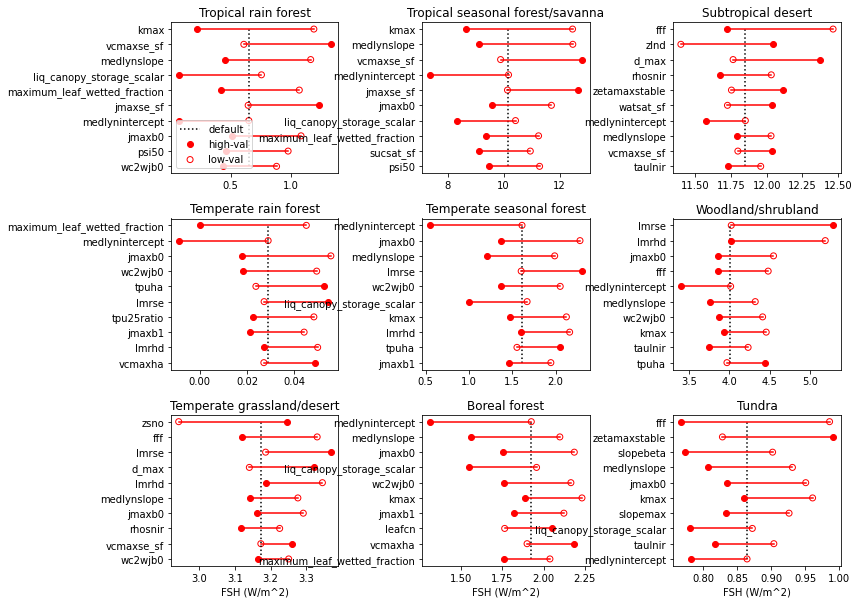

In [43]:
### exclude ice sheet
plt.figure(figsize=[12,10])
ll=True
for i in 1+np.arange(9):
    plt.subplot(3,3,i)
    
    b = str(dsb.biome_name.isel(biome_id=i).values)
    
    plot20(da.isel(biome=i),10,b,ll=ll,xstr=datavar)
    ll=False
    if i<7:
        plt.xlabel('')
        
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.5)

# Analysis: global mean and interannual variability

In [110]:
cutoff_num =5
params_top5 = []
params_biome = []
params_criteria = []
params_rank = []
params_variable = []
params_measure = []

uniques = list(np.unique(ds.param))
uniques.remove('default')

for datavar in data_vars2:
    print(datavar)
    [da_mean,da_ann] = calc_mean(ds, datavar)
    iav = calc_iav(ds, datavar, da_ann=da_ann)
    
    # Mean
    [xmins,xmaxs,pvals] = top_n(da_mean,
                                cutoff_num,params,minmax,uniques)
    pvals.reverse()
    xmins.reverse()
    xmaxs.reverse()
    params_top5 = params_top5 + pvals[0:cutoff_num]
    params_biome = params_biome+['global']*cutoff_num
    params_criteria = params_criteria+[datavar+'_MEAN_global']*cutoff_num
    params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()
    params_variable = params_variable+[datavar]*cutoff_num
    params_measure = params_measure+['mean']*cutoff_num

    # IAV
    [xmins,xmaxs,pvals] = top_n(iav,cutoff_num,params,minmax,uniques)
    pvals.reverse()
    xmins.reverse()
    xmaxs.reverse()
    params_top5 = params_top5 + pvals[0:cutoff_num]
    params_biome = params_biome+['global']*cutoff_num
    params_criteria = params_criteria+[datavar+'_IAV_global']*cutoff_num
    params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()
    params_variable = params_variable+[datavar]*cutoff_num
    params_measure = params_measure+['iav']*cutoff_num

EFLX_LH_TOT
FSH
ET
TAUX
TAUY
FIRE
albedo_allSW
alb_DirVis
alb_DifVis
alb_DirNIR
alb_DifNIR
FSA
TSKIN
TSA
Q2M
U10


In [111]:
# dictionary of lists 
df_global = pd.DataFrame({'param_name': params_top5, 
                          'biome': params_biome, 
                          'criteria': params_criteria, 
                          'rank': params_rank,
                          'variable':params_variable,
                          'measure': params_measure} )

# Analysis: global hotspot coupling

In [ ]:
keys_without_h5 = []
for key in keys:
    if np.size(glob.glob('/glade/scratch/djk2120/PPEn11/hist/CTL2010/'+'*'+key+'*'+'h5'+'*.nc'))==0:
        #print(key+ ' == 0')
        keys_without_h5.append(key)
    elif np.size(glob.glob('/glade/scratch/djk2120/PPEn11/hist/CTL2010/'+'*'+key+'*'+'h5'+'*.nc'))>1:
        print(key+ ' > 1')
        #keys_without_h5.append(key)

In [ ]:
tape='h5'
data_vars = ['SOILWATER_10CM','FSH']
keys_with_h5 = keys[~keys.isin(keys_without_h5)]
dsd = get_ensemble('CTL2010',data_vars,tape,keys_with_h5,paramkey)

In [ ]:
#skip the first timestep and reindex
t=np.arange(3651)
dsd = dsd.shift(time=-1).sel(time=t<3650)

In [ ]:
x = dsd.SOILWATER_10CM.groupby('time.season')
y = dsd.FSH.groupby('time.season')
cv0 = (x-x.mean())*(y-y.mean())
cv  = cv0.groupby('time.season').sum()/x.count()
couplingIndex = (cv/x.std()).compute()

In [ ]:
hot_area = (la*(couplingIndex<-10)).sum(dim='gridcell')
rel_area = hot_area/hot_area[0,:]

Text(0.562, 0.91, 'area where TCI<-10W/m2 relative to the default model area')

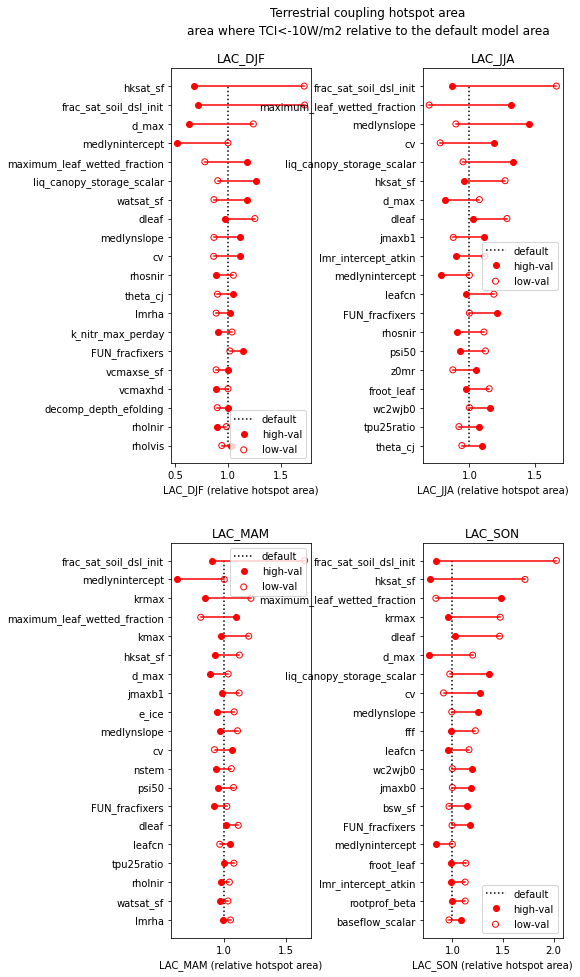

In [84]:
unit = 'relative hotspot area'
ln1  = 'Terrestrial coupling hotspot area'
ln2  = 'area where TCI<-10W/m2 relative to the default model area'
nx=20
plt.figure(figsize=[8,16])
for i,seas in zip(range(4),rel_area.season):
    sstr = str(seas.values)
    xmeans  = [];xmins=[];xmaxs=[];dxs=[]
    for u in uniques:
        pair  = find_pair(rel_area.sel(season=seas),
                          dsd.param,dsd.minmax,u)
        xmin  = pair[0].values
        xmax  = pair[1].values
        dx    = abs(xmax-xmin)
        
        xmins.append(xmin)
        xmaxs.append(xmax)
        dxs.append(dx)
        
    ranks = np.argsort(dxs)

    pvals = [uniques[ranks[i]] for i in range(-nx,0)]
    xmins = [xmins[ranks[i]]   for i in range(-nx,0)]
    xmaxs = [xmaxs[ranks[i]]   for i in range(-nx,0)]
    
    plt.subplot(2,2,i+1)
    plot20('LAC',xdef,xmins,xmaxs,pvals,sstr,unit)

plt.subplots_adjust(wspace=0.8)
plt.subplots_adjust(left=0.22) 
plt.figtext(0.562,0.925,ln1,fontsize=12,ha='center')
plt.figtext(0.562,0.91, ln2,fontsize=12,ha='center')
#plt.savefig('../figs/LAcoupling_top20.pdf')

# Combine all criteria

In [112]:
df_all = pd.concat([df_biomes, df_global], ignore_index=True)

In [113]:
print(np.shape(df_all['param_name'].value_counts()))
print(np.shape(df_all['param_name'][df_all['rank']<=5].value_counts()))
#df_all['param_name'][df_all['rank']<=5].value_counts()

(69,)
(69,)


In [115]:
df_all.to_csv('param_rankings.csv')

In [120]:
df_all[df_all.variable=='EFLX_LH_TOT'][df_all.biome=='global']

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,param_name,biome,criteria,rank,variable,measure
1600,kmax,global,EFLX_LH_TOT_MEAN_global,1,EFLX_LH_TOT,mean
1601,medlynintercept,global,EFLX_LH_TOT_MEAN_global,2,EFLX_LH_TOT,mean
1602,vcmaxse_sf,global,EFLX_LH_TOT_MEAN_global,3,EFLX_LH_TOT,mean
1603,medlynslope,global,EFLX_LH_TOT_MEAN_global,4,EFLX_LH_TOT,mean
1604,lmrse,global,EFLX_LH_TOT_MEAN_global,5,EFLX_LH_TOT,mean
1605,frac_sat_soil_dsl_init,global,EFLX_LH_TOT_IAV_global,1,EFLX_LH_TOT,iav
1606,vcmaxse_sf,global,EFLX_LH_TOT_IAV_global,2,EFLX_LH_TOT,iav
1607,fff,global,EFLX_LH_TOT_IAV_global,3,EFLX_LH_TOT,iav
1608,d_max,global,EFLX_LH_TOT_IAV_global,4,EFLX_LH_TOT,iav
1609,jmaxse_sf,global,EFLX_LH_TOT_IAV_global,5,EFLX_LH_TOT,iav
